# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [2]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenate = layers.concatenate([upsample, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenate, filters, strides=1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [7]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks.
    print("inputs shape", inputs.shape)
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    layer_1 = encoder_block(inputs, 32, 2)
    print("layer_1 shape", layer_1.shape)
    
    layer_2 = encoder_block(layer_1, 64, 2)
    print("layer_2 shape", layer_2.shape)
    
    layer_3 = encoder_block(layer_2, 128, 2)
    print("layer_3 shape", layer_3.shape)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    layer_4 = conv2d_batchnorm(layer_3, 256, 1, 1)
    print("layer_4 shape", layer_4.shape)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer_5 = decoder_block(layer_4, layer_2, 128)
    print("layer_5 shape", layer_5.shape)
    
    layer_6 = decoder_block(layer_5, layer_1, 64)
    print("layer_6 shape", layer_6.shape)
    
    layer_7 = decoder_block(layer_6, inputs, 32)
    print("layer_7 shape", layer_7.shape)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer_7)
    print("outputs shape:", outputs.shape)
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

inputs shape (?, 160, 160, 3)
layer_1 shape (?, 80, 80, 32)
layer_2 shape (?, 40, 40, 64)
layer_3 shape (?, 20, 20, 128)
layer_4 shape (?, 20, 20, 256)
layer_5 shape (?, 40, 40, 128)
layer_6 shape (?, 80, 80, 64)
layer_7 shape (?, 160, 160, 32)
outputs shape: (?, 160, 160, 3)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [56]:
learning_rate = 0.1 # Refer from DNN_lab value
batch_size = 80 # Refer from DNN_lab value 
num_epochs = 100 # Refer from DNN_lab value 
steps_per_epoch = 52 # Default: 200 - 4131 images/batch_size
validation_steps = 15 # 1184 images/batch_size
workers = 4 # Default: 2

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.0695

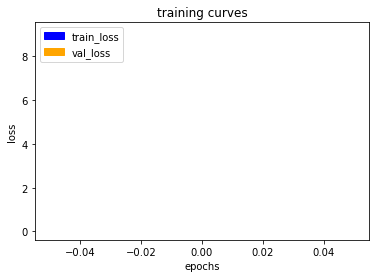

52/52 [==============================] - 56s - loss: 0.0692 - val_loss: 9.1067
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.0457

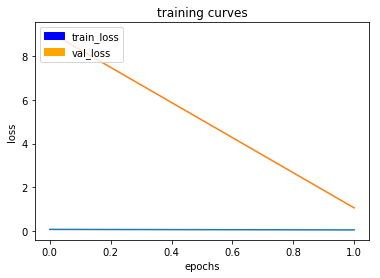

52/52 [==============================] - 54s - loss: 0.0457 - val_loss: 1.0560
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0416

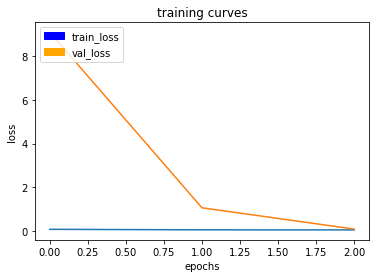

52/52 [==============================] - 53s - loss: 0.0416 - val_loss: 0.0808
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.0380

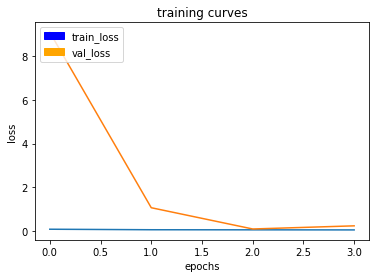

52/52 [==============================] - 54s - loss: 0.0379 - val_loss: 0.2248
Epoch 5/100
51/52 [============================>.] - ETA: 0s - loss: 0.0378

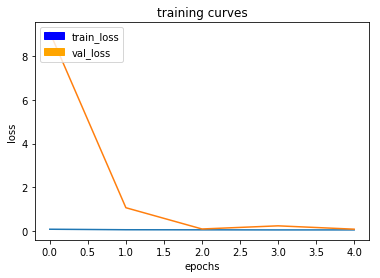

52/52 [==============================] - 53s - loss: 0.0378 - val_loss: 0.0716
Epoch 6/100
51/52 [============================>.] - ETA: 0s - loss: 0.0361

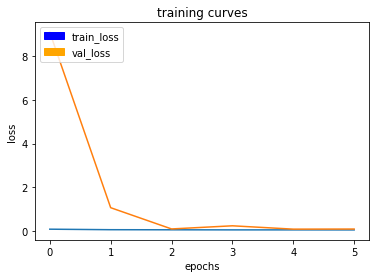

52/52 [==============================] - 53s - loss: 0.0361 - val_loss: 0.0762
Epoch 7/100
51/52 [============================>.] - ETA: 0s - loss: 0.0327

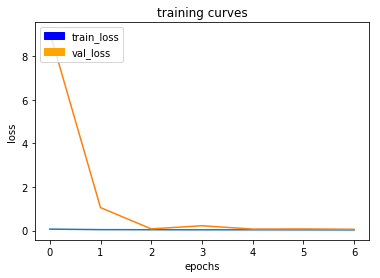

52/52 [==============================] - 53s - loss: 0.0327 - val_loss: 0.0624
Epoch 8/100
51/52 [============================>.] - ETA: 0s - loss: 0.0315

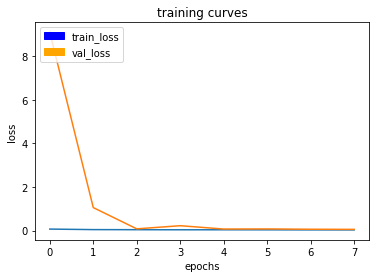

52/52 [==============================] - 53s - loss: 0.0315 - val_loss: 0.0567
Epoch 9/100
51/52 [============================>.] - ETA: 0s - loss: 0.0324

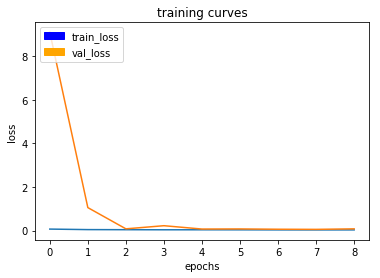

52/52 [==============================] - 53s - loss: 0.0324 - val_loss: 0.0805
Epoch 10/100
51/52 [============================>.] - ETA: 0s - loss: 0.0294

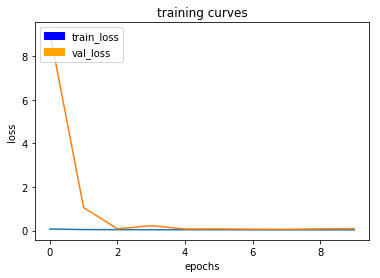

52/52 [==============================] - 54s - loss: 0.0296 - val_loss: 0.0904
Epoch 11/100
51/52 [============================>.] - ETA: 0s - loss: 0.0305

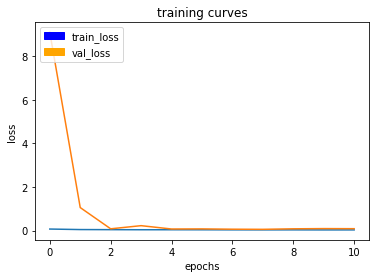

52/52 [==============================] - 54s - loss: 0.0305 - val_loss: 0.0861
Epoch 12/100
51/52 [============================>.] - ETA: 0s - loss: 0.0310

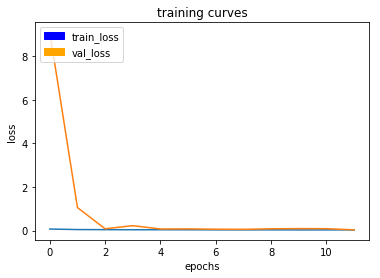

52/52 [==============================] - 53s - loss: 0.0308 - val_loss: 0.0323
Epoch 13/100
51/52 [============================>.] - ETA: 0s - loss: 0.0276

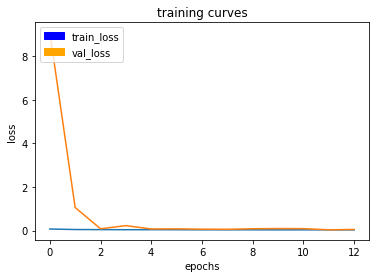

52/52 [==============================] - 54s - loss: 0.0278 - val_loss: 0.0486
Epoch 14/100
51/52 [============================>.] - ETA: 0s - loss: 0.0283

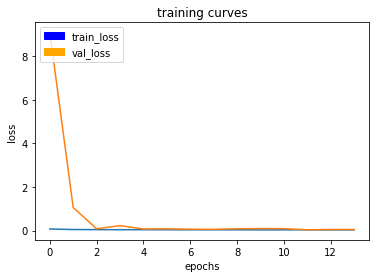

52/52 [==============================] - 54s - loss: 0.0283 - val_loss: 0.0463
Epoch 15/100
51/52 [============================>.] - ETA: 0s - loss: 0.0271

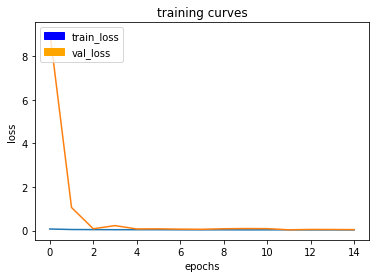

52/52 [==============================] - 53s - loss: 0.0276 - val_loss: 0.0408
Epoch 16/100
51/52 [============================>.] - ETA: 0s - loss: 0.0265

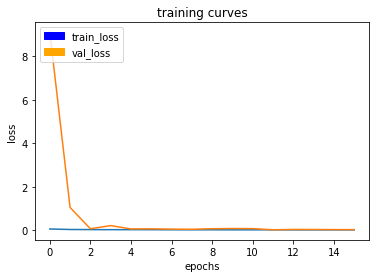

52/52 [==============================] - 54s - loss: 0.0264 - val_loss: 0.0398
Epoch 17/100
51/52 [============================>.] - ETA: 0s - loss: 0.0257

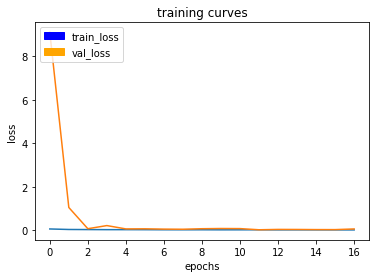

52/52 [==============================] - 53s - loss: 0.0257 - val_loss: 0.0699
Epoch 18/100
51/52 [============================>.] - ETA: 0s - loss: 0.0258

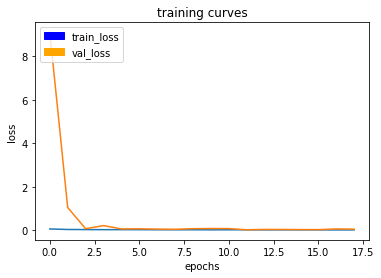

52/52 [==============================] - 54s - loss: 0.0256 - val_loss: 0.0597
Epoch 19/100
51/52 [============================>.] - ETA: 0s - loss: 0.0239

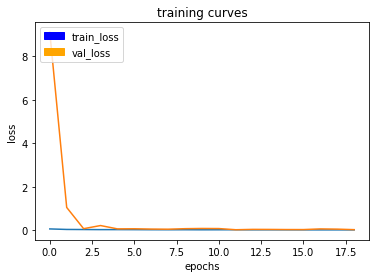

52/52 [==============================] - 54s - loss: 0.0239 - val_loss: 0.0361
Epoch 20/100
51/52 [============================>.] - ETA: 0s - loss: 0.0251

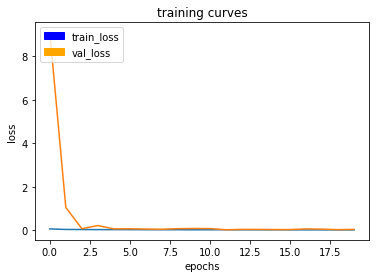

52/52 [==============================] - 53s - loss: 0.0251 - val_loss: 0.0479
Epoch 21/100
51/52 [============================>.] - ETA: 0s - loss: 0.0237

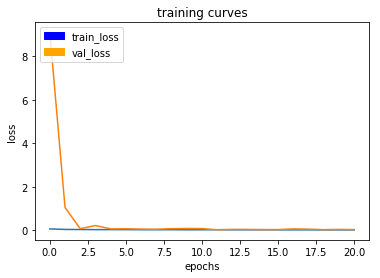

52/52 [==============================] - 54s - loss: 0.0237 - val_loss: 0.0388
Epoch 22/100
51/52 [============================>.] - ETA: 0s - loss: 0.0225

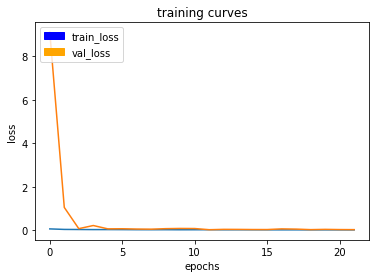

52/52 [==============================] - 54s - loss: 0.0228 - val_loss: 0.0357
Epoch 23/100
51/52 [============================>.] - ETA: 0s - loss: 0.0245

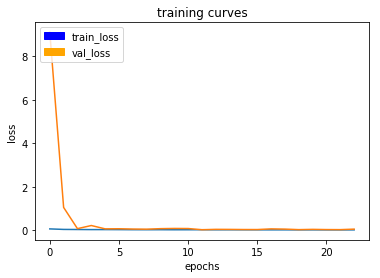

52/52 [==============================] - 54s - loss: 0.0244 - val_loss: 0.0588
Epoch 24/100
51/52 [============================>.] - ETA: 0s - loss: 0.0233

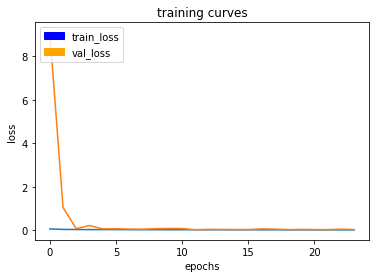

52/52 [==============================] - 53s - loss: 0.0232 - val_loss: 0.0380
Epoch 25/100
51/52 [============================>.] - ETA: 0s - loss: 0.0219

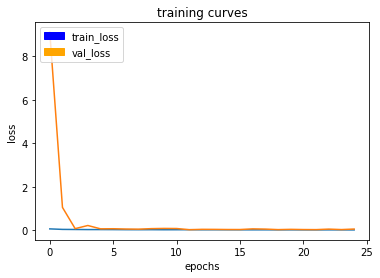

52/52 [==============================] - 54s - loss: 0.0218 - val_loss: 0.0621
Epoch 26/100
51/52 [============================>.] - ETA: 0s - loss: 0.0215

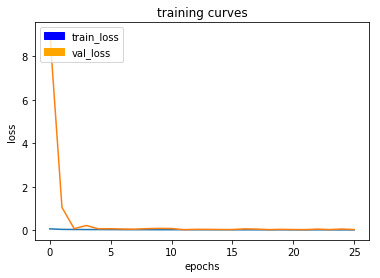

52/52 [==============================] - 54s - loss: 0.0214 - val_loss: 0.0379
Epoch 27/100
51/52 [============================>.] - ETA: 0s - loss: 0.0219

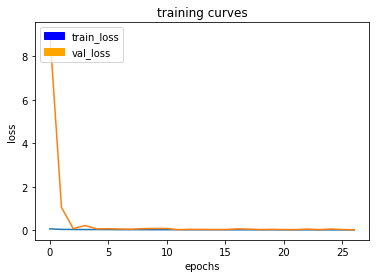

52/52 [==============================] - 54s - loss: 0.0221 - val_loss: 0.0303
Epoch 28/100
51/52 [============================>.] - ETA: 0s - loss: 0.0211

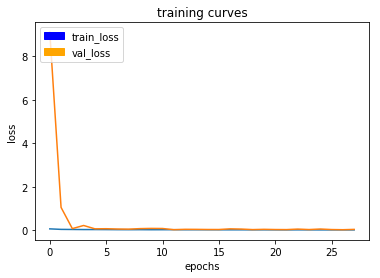

52/52 [==============================] - 54s - loss: 0.0211 - val_loss: 0.0451
Epoch 29/100
51/52 [============================>.] - ETA: 0s - loss: 0.0212

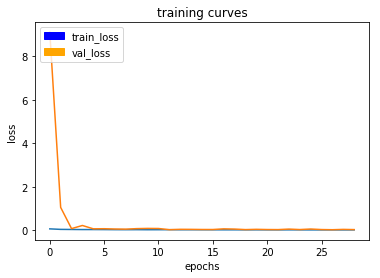

52/52 [==============================] - 54s - loss: 0.0212 - val_loss: 0.0360
Epoch 30/100
51/52 [============================>.] - ETA: 0s - loss: 0.0216

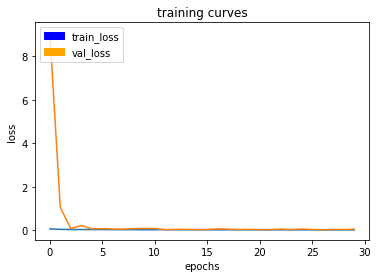

52/52 [==============================] - 54s - loss: 0.0218 - val_loss: 0.0578
Epoch 31/100
51/52 [============================>.] - ETA: 0s - loss: 0.0202

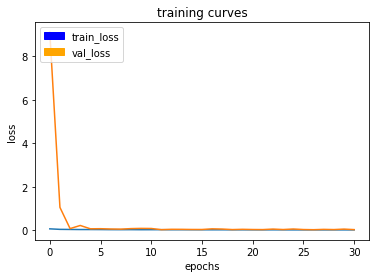

52/52 [==============================] - 54s - loss: 0.0202 - val_loss: 0.0340
Epoch 32/100
51/52 [============================>.] - ETA: 0s - loss: 0.0189

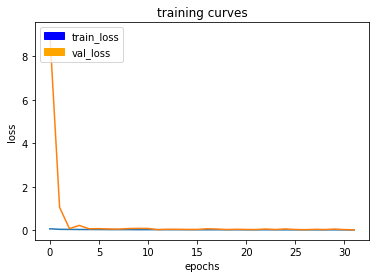

52/52 [==============================] - 54s - loss: 0.0189 - val_loss: 0.0236
Epoch 33/100
51/52 [============================>.] - ETA: 0s - loss: 0.0222

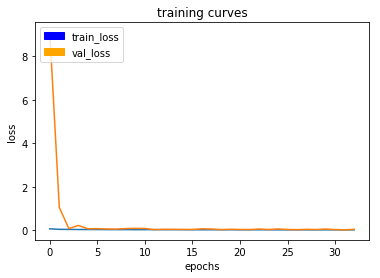

52/52 [==============================] - 54s - loss: 0.0221 - val_loss: 0.0455
Epoch 34/100
51/52 [============================>.] - ETA: 0s - loss: 0.0206

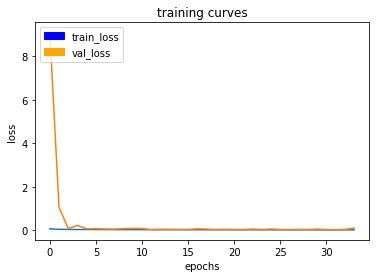

52/52 [==============================] - 53s - loss: 0.0207 - val_loss: 0.1054
Epoch 35/100
51/52 [============================>.] - ETA: 0s - loss: 0.0226

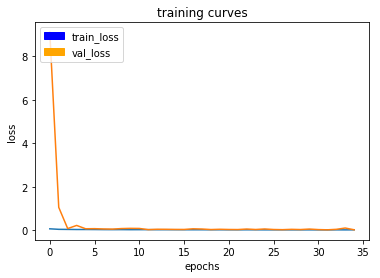

52/52 [==============================] - 53s - loss: 0.0225 - val_loss: 0.0252
Epoch 36/100
51/52 [============================>.] - ETA: 0s - loss: 0.0192

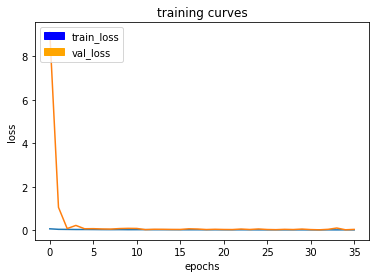

52/52 [==============================] - 54s - loss: 0.0195 - val_loss: 0.0421
Epoch 37/100
51/52 [============================>.] - ETA: 0s - loss: 0.0193

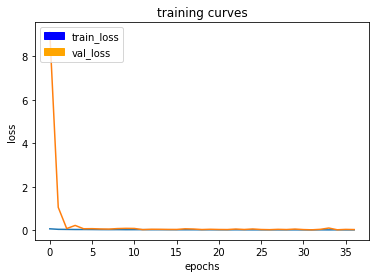

52/52 [==============================] - 53s - loss: 0.0193 - val_loss: 0.0351
Epoch 38/100
51/52 [============================>.] - ETA: 0s - loss: 0.0203

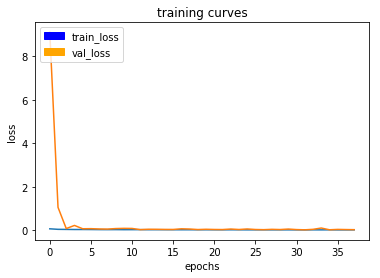

52/52 [==============================] - 54s - loss: 0.0202 - val_loss: 0.0300
Epoch 39/100
51/52 [============================>.] - ETA: 0s - loss: 0.0189

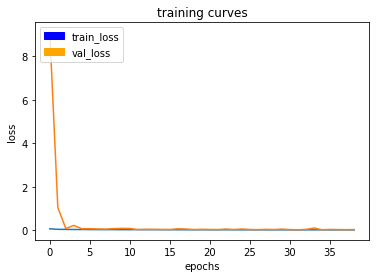

52/52 [==============================] - 53s - loss: 0.0188 - val_loss: 0.0352
Epoch 40/100
51/52 [============================>.] - ETA: 0s - loss: 0.0177

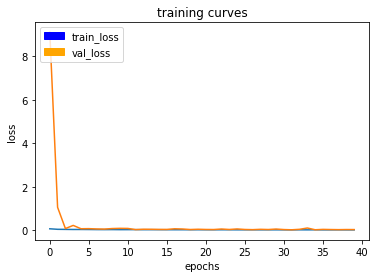

52/52 [==============================] - 54s - loss: 0.0177 - val_loss: 0.0333
Epoch 41/100
51/52 [============================>.] - ETA: 0s - loss: 0.0174

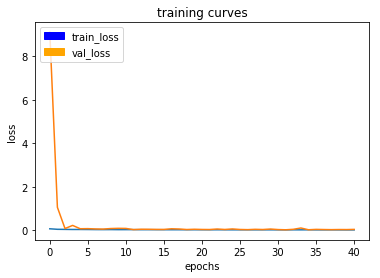

52/52 [==============================] - 54s - loss: 0.0176 - val_loss: 0.0415
Epoch 42/100
51/52 [============================>.] - ETA: 0s - loss: 0.0174

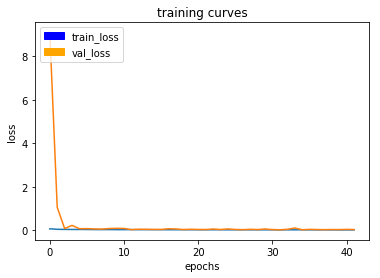

52/52 [==============================] - 53s - loss: 0.0174 - val_loss: 0.0343
Epoch 43/100
51/52 [============================>.] - ETA: 0s - loss: 0.0192

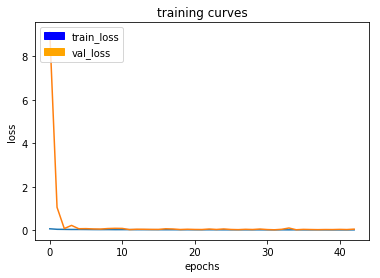

52/52 [==============================] - 53s - loss: 0.0192 - val_loss: 0.0536
Epoch 44/100
51/52 [============================>.] - ETA: 0s - loss: 0.0180

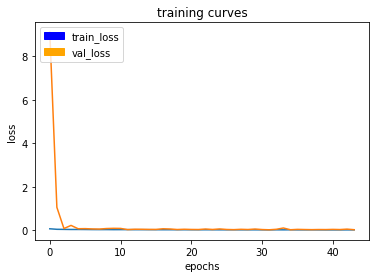

52/52 [==============================] - 54s - loss: 0.0179 - val_loss: 0.0272
Epoch 45/100
51/52 [============================>.] - ETA: 0s - loss: 0.0176

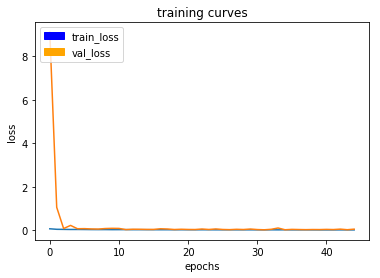

52/52 [==============================] - 54s - loss: 0.0176 - val_loss: 0.0527
Epoch 46/100
51/52 [============================>.] - ETA: 0s - loss: 0.0179

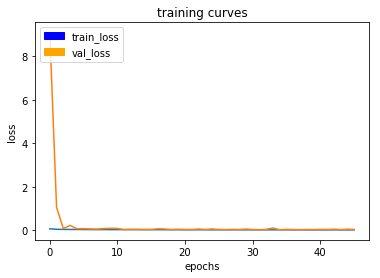

52/52 [==============================] - 53s - loss: 0.0180 - val_loss: 0.0391
Epoch 47/100
51/52 [============================>.] - ETA: 0s - loss: 0.0184

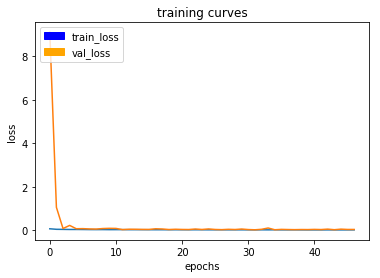

52/52 [==============================] - 53s - loss: 0.0183 - val_loss: 0.0388
Epoch 48/100
51/52 [============================>.] - ETA: 0s - loss: 0.0187

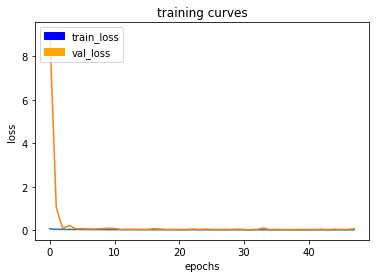

52/52 [==============================] - 54s - loss: 0.0187 - val_loss: 0.0737
Epoch 49/100
51/52 [============================>.] - ETA: 0s - loss: 0.0164

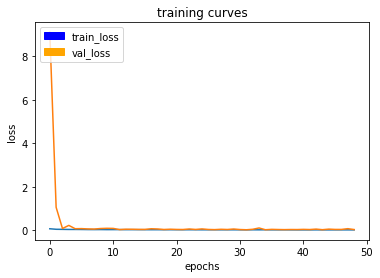

52/52 [==============================] - 53s - loss: 0.0165 - val_loss: 0.0331
Epoch 50/100
51/52 [============================>.] - ETA: 0s - loss: 0.0164

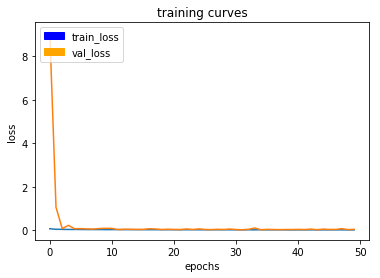

52/52 [==============================] - 54s - loss: 0.0164 - val_loss: 0.0426
Epoch 51/100
51/52 [============================>.] - ETA: 0s - loss: 0.0179

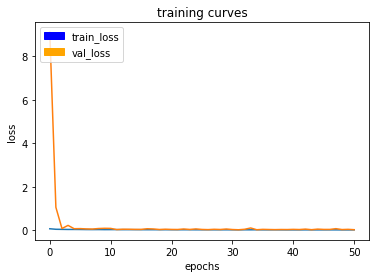

52/52 [==============================] - 54s - loss: 0.0179 - val_loss: 0.0265
Epoch 52/100
51/52 [============================>.] - ETA: 0s - loss: 0.0163

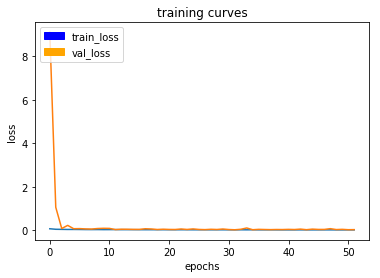

52/52 [==============================] - 53s - loss: 0.0163 - val_loss: 0.0296
Epoch 53/100
51/52 [============================>.] - ETA: 0s - loss: 0.0155

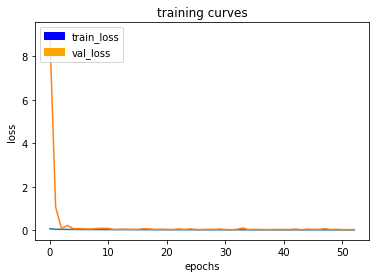

52/52 [==============================] - 53s - loss: 0.0156 - val_loss: 0.0328
Epoch 54/100
51/52 [============================>.] - ETA: 0s - loss: 0.0197

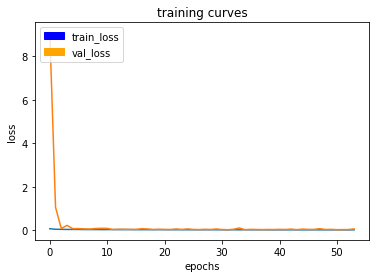

52/52 [==============================] - 54s - loss: 0.0197 - val_loss: 0.0617
Epoch 55/100
51/52 [============================>.] - ETA: 0s - loss: 0.0180

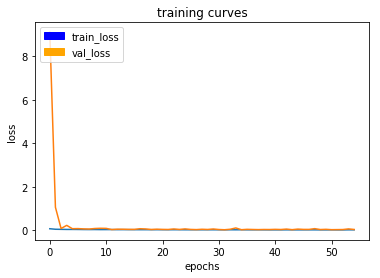

52/52 [==============================] - 54s - loss: 0.0180 - val_loss: 0.0357
Epoch 56/100
51/52 [============================>.] - ETA: 0s - loss: 0.0167

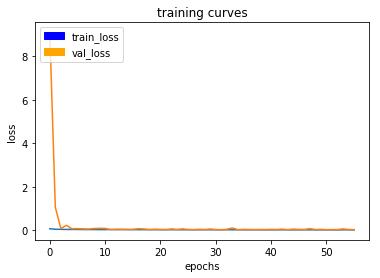

52/52 [==============================] - 53s - loss: 0.0167 - val_loss: 0.0298
Epoch 57/100
51/52 [============================>.] - ETA: 0s - loss: 0.0155

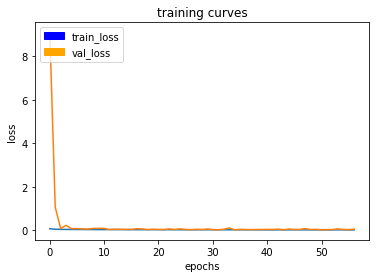

52/52 [==============================] - 53s - loss: 0.0156 - val_loss: 0.0523
Epoch 58/100
51/52 [============================>.] - ETA: 0s - loss: 0.0163

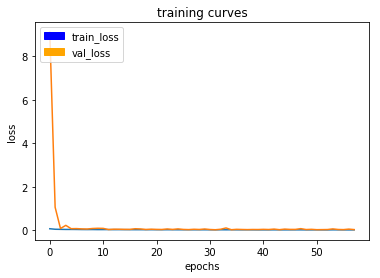

52/52 [==============================] - 53s - loss: 0.0163 - val_loss: 0.0306
Epoch 59/100
51/52 [============================>.] - ETA: 0s - loss: 0.0147

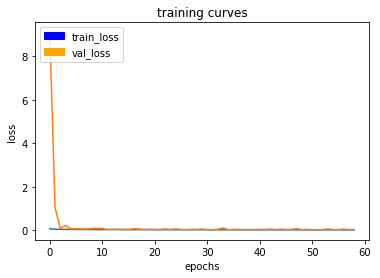

52/52 [==============================] - 53s - loss: 0.0147 - val_loss: 0.0334
Epoch 60/100
51/52 [============================>.] - ETA: 0s - loss: 0.0147

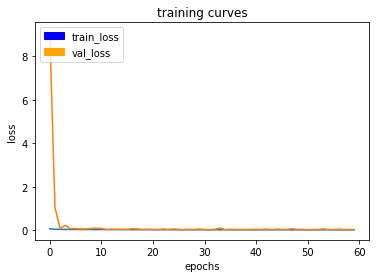

52/52 [==============================] - 53s - loss: 0.0147 - val_loss: 0.0310
Epoch 61/100
51/52 [============================>.] - ETA: 0s - loss: 0.0149

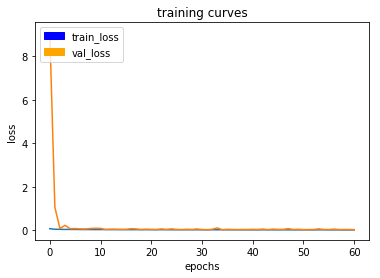

52/52 [==============================] - 53s - loss: 0.0148 - val_loss: 0.0291
Epoch 62/100
51/52 [============================>.] - ETA: 0s - loss: 0.0149

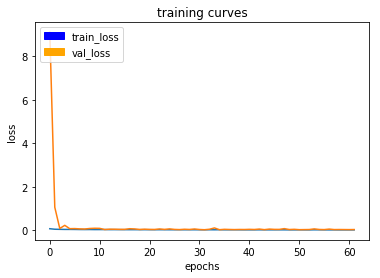

52/52 [==============================] - 53s - loss: 0.0148 - val_loss: 0.0320
Epoch 63/100
51/52 [============================>.] - ETA: 0s - loss: 0.0177

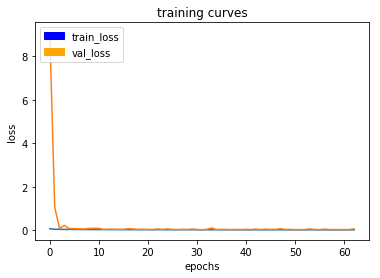

52/52 [==============================] - 53s - loss: 0.0177 - val_loss: 0.0627
Epoch 64/100
51/52 [============================>.] - ETA: 0s - loss: 0.0156

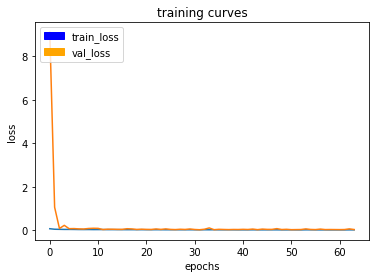

52/52 [==============================] - 54s - loss: 0.0156 - val_loss: 0.0320
Epoch 65/100
51/52 [============================>.] - ETA: 0s - loss: 0.0148

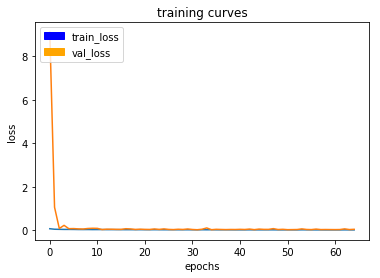

52/52 [==============================] - 53s - loss: 0.0149 - val_loss: 0.0430
Epoch 66/100
51/52 [============================>.] - ETA: 0s - loss: 0.0148

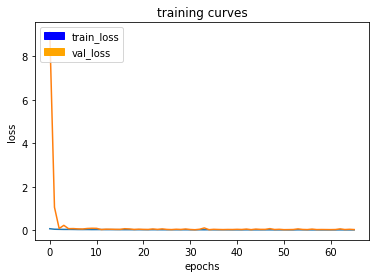

52/52 [==============================] - 54s - loss: 0.0148 - val_loss: 0.0309
Epoch 67/100
51/52 [============================>.] - ETA: 0s - loss: 0.0152

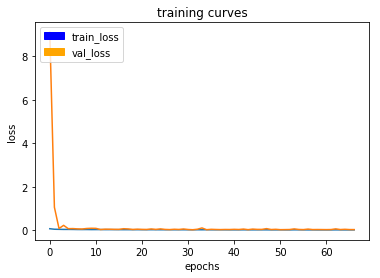

52/52 [==============================] - 54s - loss: 0.0152 - val_loss: 0.0301
Epoch 68/100
51/52 [============================>.] - ETA: 0s - loss: 0.0143

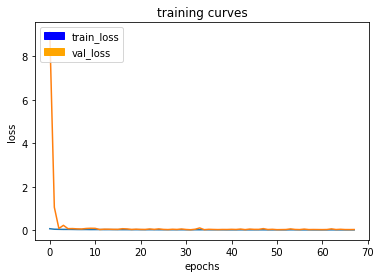

52/52 [==============================] - 53s - loss: 0.0143 - val_loss: 0.0324
Epoch 69/100
51/52 [============================>.] - ETA: 0s - loss: 0.0137

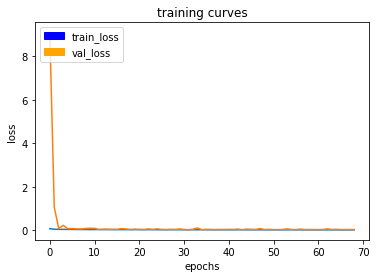

52/52 [==============================] - 54s - loss: 0.0138 - val_loss: 0.0328
Epoch 70/100
51/52 [============================>.] - ETA: 0s - loss: 0.0150

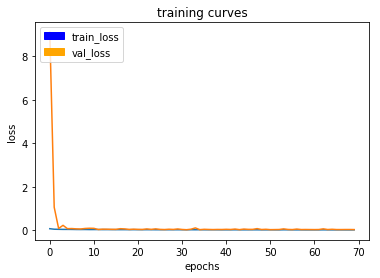

52/52 [==============================] - 53s - loss: 0.0150 - val_loss: 0.0294
Epoch 71/100
51/52 [============================>.] - ETA: 0s - loss: 0.0149

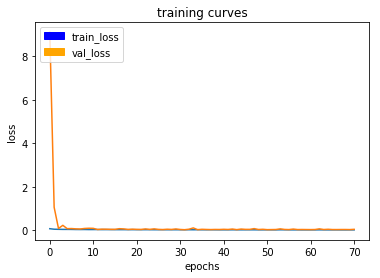

52/52 [==============================] - 53s - loss: 0.0149 - val_loss: 0.0408
Epoch 72/100
51/52 [============================>.] - ETA: 0s - loss: 0.0166

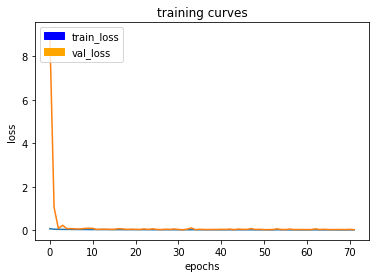

52/52 [==============================] - 53s - loss: 0.0166 - val_loss: 0.0239
Epoch 73/100
51/52 [============================>.] - ETA: 0s - loss: 0.0142

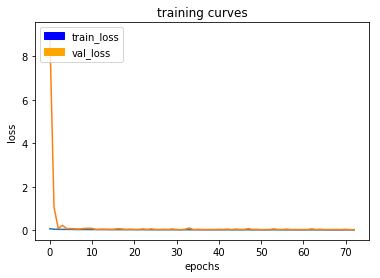

52/52 [==============================] - 54s - loss: 0.0142 - val_loss: 0.0286
Epoch 74/100
51/52 [============================>.] - ETA: 0s - loss: 0.0139

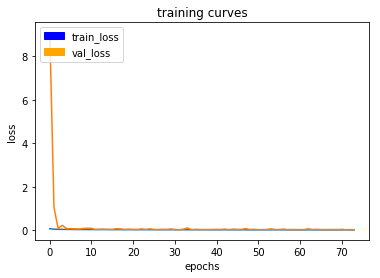

52/52 [==============================] - 54s - loss: 0.0139 - val_loss: 0.0247
Epoch 75/100
51/52 [============================>.] - ETA: 0s - loss: 0.0154

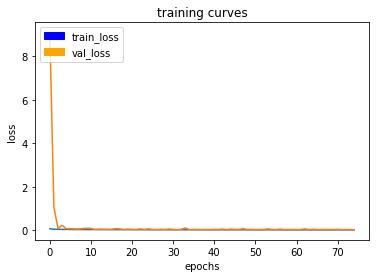

52/52 [==============================] - 53s - loss: 0.0153 - val_loss: 0.0225
Epoch 76/100
51/52 [============================>.] - ETA: 0s - loss: 0.0143

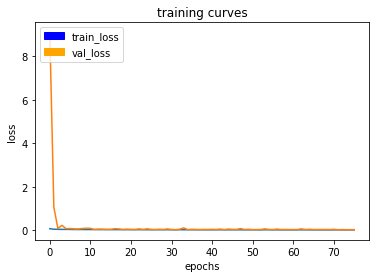

52/52 [==============================] - 54s - loss: 0.0146 - val_loss: 0.0299
Epoch 77/100
51/52 [============================>.] - ETA: 0s - loss: 0.0137

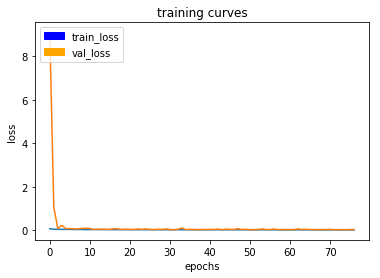

52/52 [==============================] - 53s - loss: 0.0136 - val_loss: 0.0298
Epoch 78/100
51/52 [============================>.] - ETA: 0s - loss: 0.0127

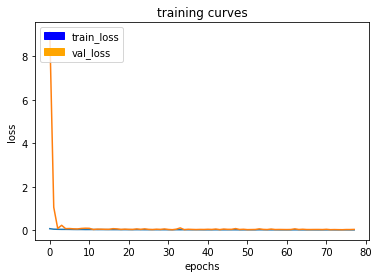

52/52 [==============================] - 53s - loss: 0.0127 - val_loss: 0.0356
Epoch 79/100
51/52 [============================>.] - ETA: 0s - loss: 0.0126

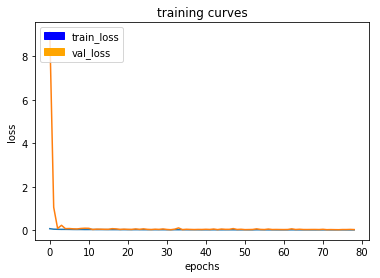

52/52 [==============================] - 53s - loss: 0.0126 - val_loss: 0.0282
Epoch 80/100
51/52 [============================>.] - ETA: 0s - loss: 0.0149

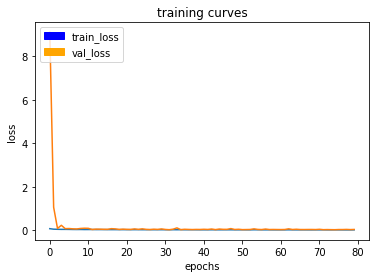

52/52 [==============================] - 53s - loss: 0.0149 - val_loss: 0.0341
Epoch 81/100
51/52 [============================>.] - ETA: 0s - loss: 0.0133

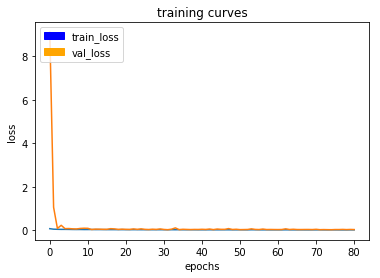

52/52 [==============================] - 54s - loss: 0.0132 - val_loss: 0.0292
Epoch 82/100
51/52 [============================>.] - ETA: 0s - loss: 0.0125

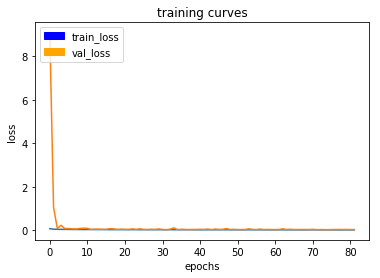

52/52 [==============================] - 54s - loss: 0.0126 - val_loss: 0.0291
Epoch 83/100
51/52 [============================>.] - ETA: 0s - loss: 0.0133

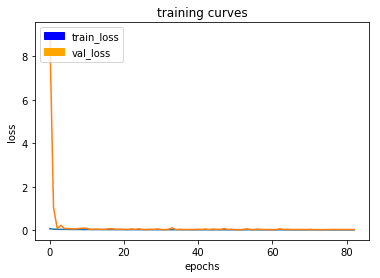

52/52 [==============================] - 54s - loss: 0.0133 - val_loss: 0.0297
Epoch 84/100
51/52 [============================>.] - ETA: 0s - loss: 0.0127

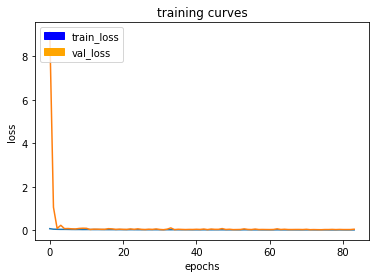

52/52 [==============================] - 53s - loss: 0.0127 - val_loss: 0.0446
Epoch 85/100
51/52 [============================>.] - ETA: 0s - loss: 0.0126

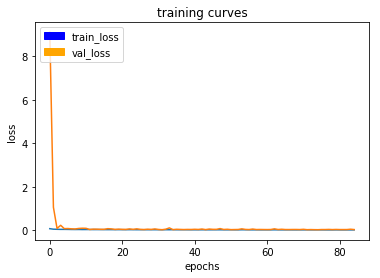

52/52 [==============================] - 53s - loss: 0.0126 - val_loss: 0.0289
Epoch 86/100
51/52 [============================>.] - ETA: 0s - loss: 0.0120

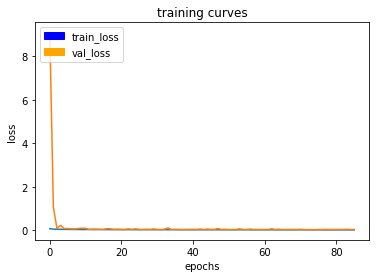

52/52 [==============================] - 53s - loss: 0.0120 - val_loss: 0.0364
Epoch 87/100
51/52 [============================>.] - ETA: 0s - loss: 0.0177

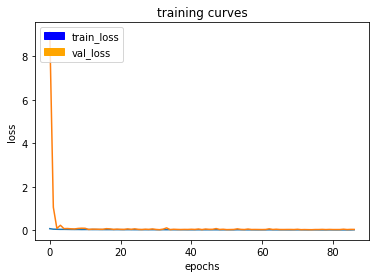

52/52 [==============================] - 54s - loss: 0.0177 - val_loss: 0.0351
Epoch 88/100
51/52 [============================>.] - ETA: 0s - loss: 0.0173

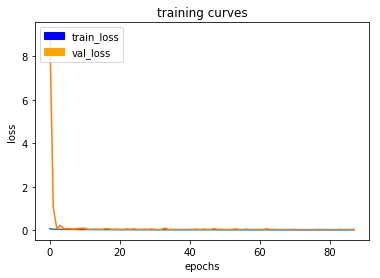

52/52 [==============================] - 54s - loss: 0.0173 - val_loss: 0.0351
Epoch 89/100
51/52 [============================>.] - ETA: 0s - loss: 0.0141

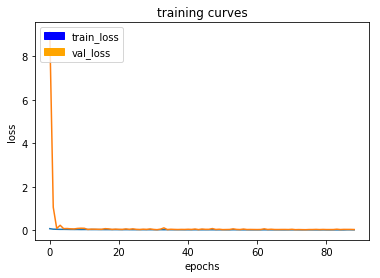

52/52 [==============================] - 54s - loss: 0.0141 - val_loss: 0.0302
Epoch 90/100
51/52 [============================>.] - ETA: 0s - loss: 0.0133

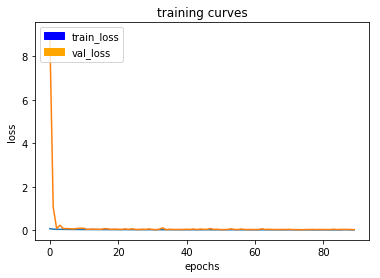

52/52 [==============================] - 54s - loss: 0.0133 - val_loss: 0.0264
Epoch 91/100
51/52 [============================>.] - ETA: 0s - loss: 0.0126

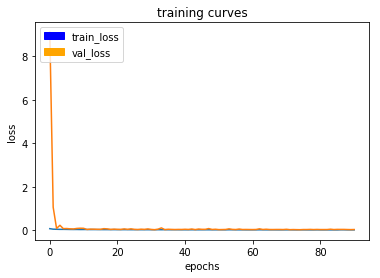

52/52 [==============================] - 53s - loss: 0.0126 - val_loss: 0.0304
Epoch 92/100
51/52 [============================>.] - ETA: 0s - loss: 0.0120

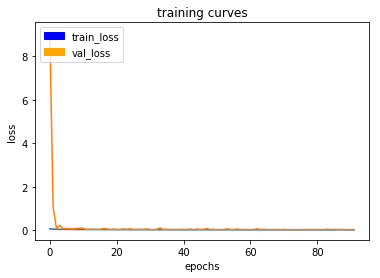

52/52 [==============================] - 53s - loss: 0.0120 - val_loss: 0.0250
Epoch 93/100
51/52 [============================>.] - ETA: 0s - loss: 0.0120

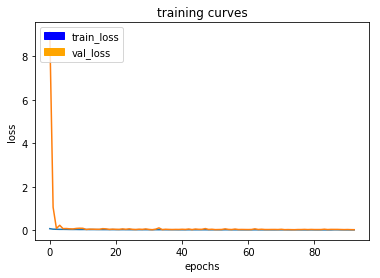

52/52 [==============================] - 53s - loss: 0.0119 - val_loss: 0.0227
Epoch 94/100
51/52 [============================>.] - ETA: 0s - loss: 0.0118

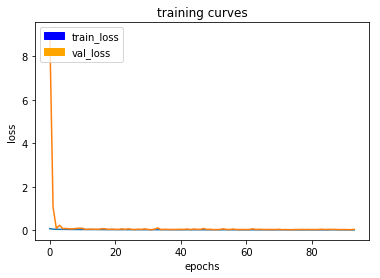

52/52 [==============================] - 54s - loss: 0.0118 - val_loss: 0.0374
Epoch 95/100
51/52 [============================>.] - ETA: 0s - loss: 0.0162

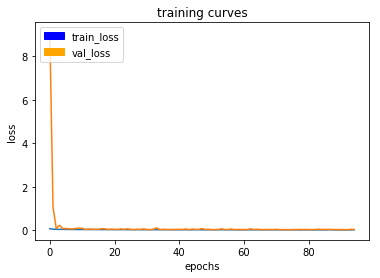

52/52 [==============================] - 54s - loss: 0.0162 - val_loss: 0.0352
Epoch 96/100
51/52 [============================>.] - ETA: 0s - loss: 0.0146

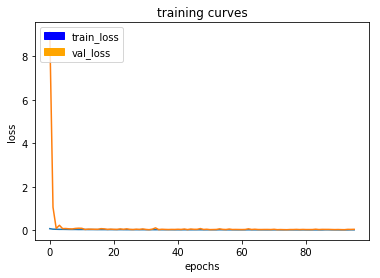

52/52 [==============================] - 54s - loss: 0.0146 - val_loss: 0.0396
Epoch 97/100
51/52 [============================>.] - ETA: 0s - loss: 0.0140

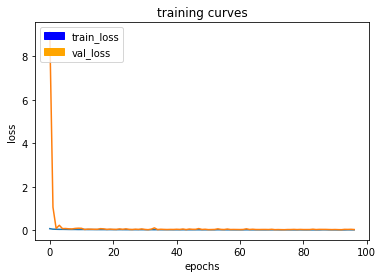

52/52 [==============================] - 53s - loss: 0.0140 - val_loss: 0.0296
Epoch 98/100
51/52 [============================>.] - ETA: 0s - loss: 0.0122

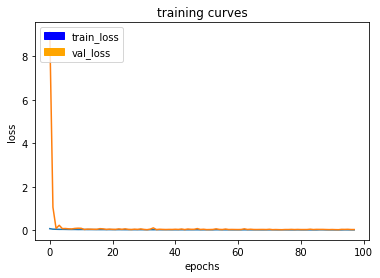

52/52 [==============================] - 54s - loss: 0.0122 - val_loss: 0.0296
Epoch 99/100
51/52 [============================>.] - ETA: 0s - loss: 0.0116

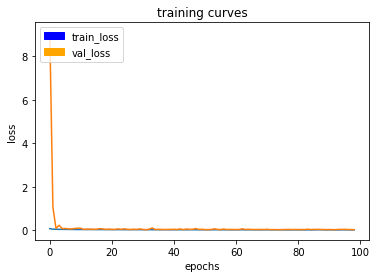

52/52 [==============================] - 54s - loss: 0.0116 - val_loss: 0.0210
Epoch 100/100
51/52 [============================>.] - ETA: 0s - loss: 0.0116

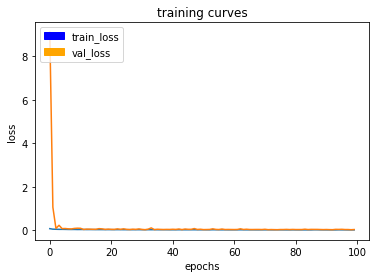

52/52 [==============================] - 54s - loss: 0.0116 - val_loss: 0.0291


In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [58]:
# Save your trained model weights
weight_file_name = 'model_weights_6'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [59]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights_6'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [60]:
run_num = 'run_6'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

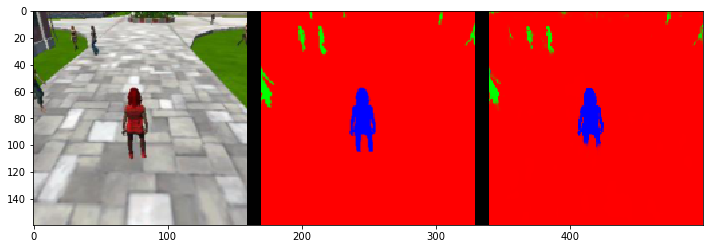

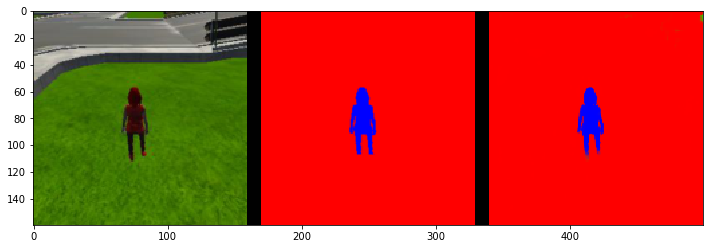

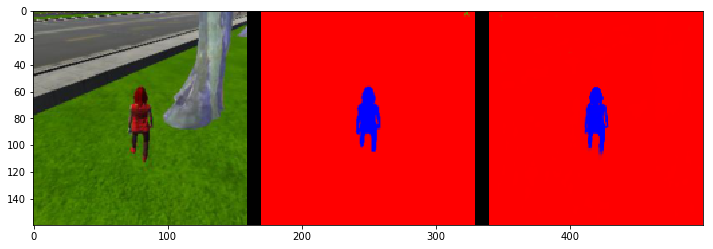

In [61]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

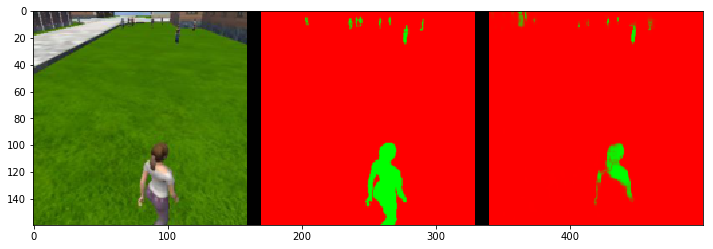

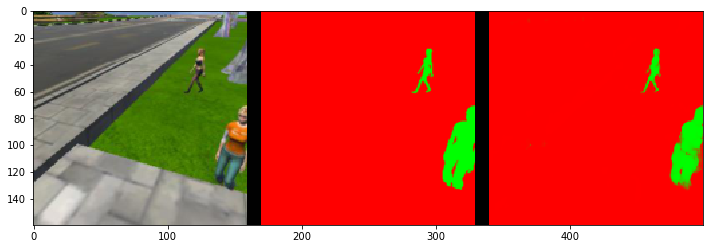

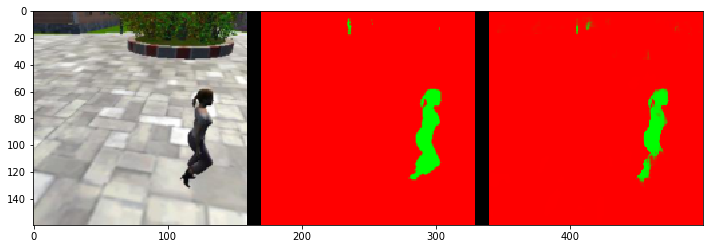

In [62]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

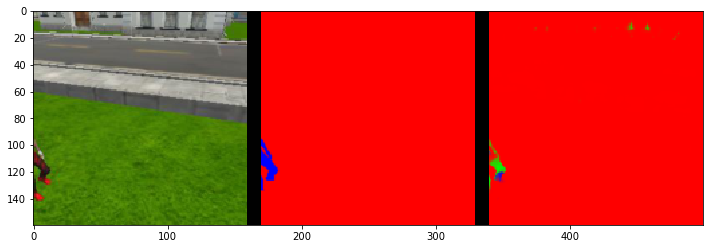

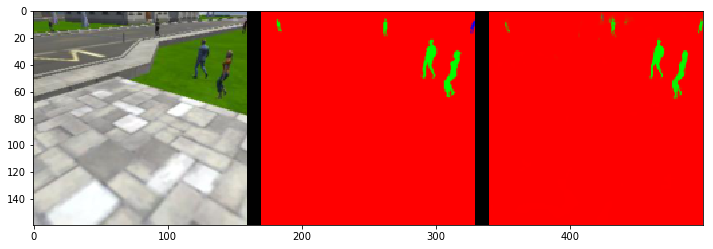

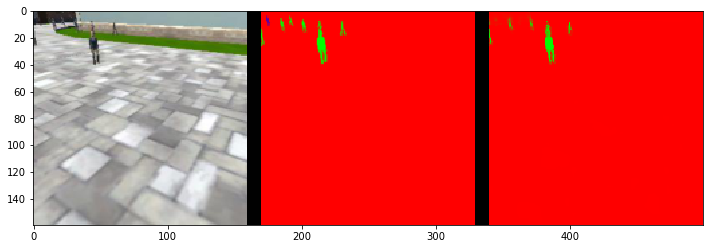

In [63]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [48]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9954833969835263
average intersection over union for other people is 0.3566784778254446
average intersection over union for the hero is 0.9035208324986789
number true positives: 539, number false positives: 0, number false negatives: 0


In [49]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.983356165360626
average intersection over union for other people is 0.6691824340295148
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 65, number false negatives: 0


In [50]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9960588461610216
average intersection over union for other people is 0.43154895903710877
average intersection over union for the hero is 0.16465491696598789
number true positives: 105, number false positives: 2, number false negatives: 196


In [51]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7100330760749725


In [52]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.534087874732


In [53]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.379220056591
